In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
import pathlib
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from IPython import display
from IPython.display import clear_output
%matplotlib inline

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
# implement image preprocessing
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [3]:
dataset, metadata = tfds.load('cycle_gan/vangogh2photo', with_info=True, as_supervised=True)

In [4]:
# split data
train_vangogh, train_photo = dataset['trainA'], dataset['trainB'].take(400)
test_vangogh, test_photo = dataset['testA'], dataset['testB']

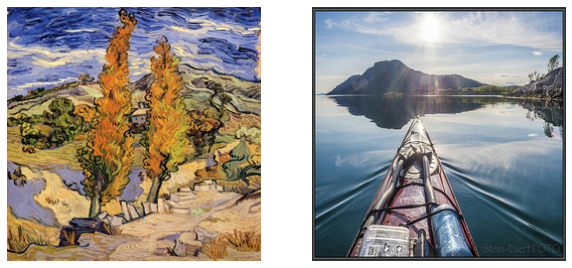

In [5]:
# plot sample images
sample_vangogh = next(iter(train_vangogh))
sample_photo = next(iter(train_photo))

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(sample_vangogh[0])
plt.axis('off')

plt.subplot(122)
plt.imshow(sample_photo[0])
plt.axis('off')
plt.show()

In [6]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
# preprocess images
train_vangogh = train_vangogh.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_photo = train_photo.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_vangogh = test_vangogh.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photo = test_photo.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

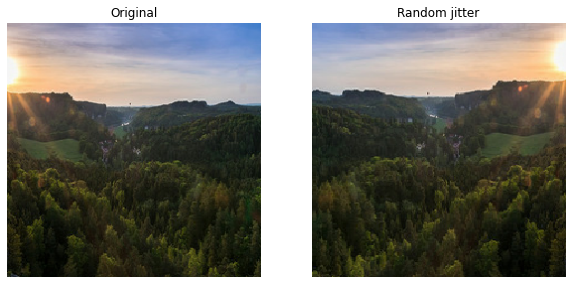

In [8]:
# plot sample images after preprocessing, compare random jitter
sample_photo = next(iter(train_photo))

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(sample_photo[0] * .5 + .5)
plt.axis('off')
plt.title('Original')

plt.subplot(122)
plt.imshow(random_jitter(sample_photo[0]) * .5 + .5)
plt.axis('off')
plt.title('Random jitter')
plt.show()

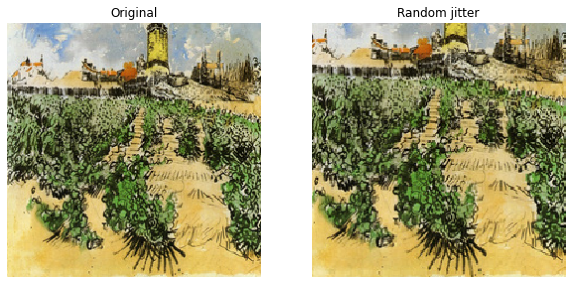

In [9]:
# plot sample images after preprocessing, compare random jitter
sample_vangogh = next(iter(train_vangogh))

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(sample_vangogh[0] * .5 + .5)
plt.axis('off')
plt.title('Original')

plt.subplot(122)
plt.imshow(random_jitter(sample_vangogh[0]) * .5 + .5)
plt.axis('off')
plt.title('Random jitter')
plt.show()

In [10]:
# import pix2pix submodels
OUTPUT_CHANNELS = 3

# vangogh2photo
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# photo2vangogh
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# classify photo
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)

# classify vangogh
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

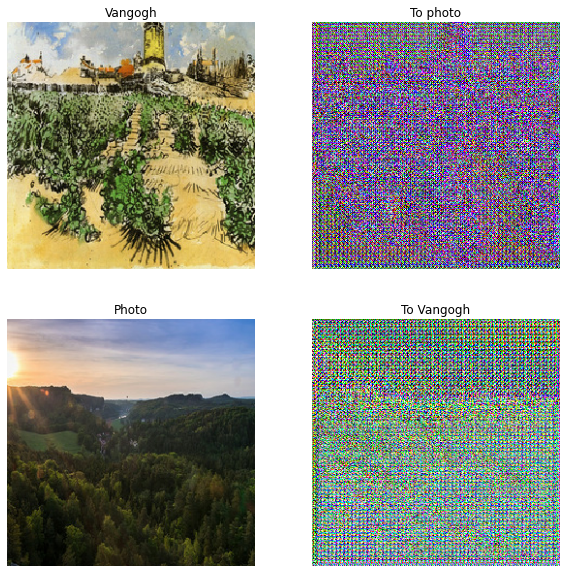

In [11]:
to_photo = generator_g(sample_vangogh)
to_vangogh = generator_f(sample_photo)
plt.figure(figsize=(10, 10))
contrast = 8

imgs = [sample_vangogh, to_photo, sample_photo, to_vangogh]
title = ['Vangogh', 'To photo', 'Photo', 'To Vangogh']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
    plt.axis('off')
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
    plt.axis('off')
plt.show()

In [12]:
# define loss function
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# loss parameter
LAMBDA = 10

In [13]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [14]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [15]:
# define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [16]:
checkpoint_path = './ckpt'
ckpt = tf.train.Checkpoint(
    generator_g=generator_g,
    generator_f=generator_f,
    discriminator_x=discriminator_x,
    discriminator_y=discriminator_y,
    generator_g_optimizer=generator_g_optimizer,
    generator_f_optimizer=generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

In [17]:
EPOCHS = 1

In [18]:
for epoch in range(EPOCHS):
  start = time.time()
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_photo, train_vangogh)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_photo)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

0
.1
2
3
4
5
6
7
8
9
10
.11
12
13
14
15
16
17
18
19
20
.21
22
23
24
25
26
27
28
29
30
.31
32
33
34
35
36
37
38
39
40
.41
42
43
44
45
46
47
48
49
50
.51
52
53
54
55
56
57
58
59
60
.61
62
63
64
65
66
67
68
69
70
.71
72
73
74
75
76
77
78
79
80
.81
82
83
84
85
86
87
